# Import Signal Labels

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

2023-09-23 20:44:20.074539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# To avoid:
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

This code creates the signals into a datastore. 

In [3]:
train_dataset = tf.data.Dataset.list_files("../data/flooddata/*/*.csv", shuffle=False)
train_dataset = train_dataset.batch(1)

2023-09-23 20:44:23.916842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 20:44:23.918060: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
files = []
for file in train_dataset:
    files.append(file.numpy().astype(str)[0])

We have used a Dataset to access the files. To train a network that can classify our signals, our data needs to be labeled. The location of these labels will depend on our data set.
Each signal in the flood data set is stored in a folder according to its class. 

In [5]:
labels = []
for file in files:
    labels.append(file.split("/")[3])
labels = pd.Categorical(labels)
labels

['depth_0_0', 'depth_0_0', 'depth_0_0', 'depth_0_0', 'depth_0_0', ..., 'depth_4_5', 'depth_4_5', 'depth_4_5', 'depth_4_5', 'depth_4_5']
Length: 222
Categories (4, object): ['depth_0_0', 'depth_0_19', 'depth_2_5', 'depth_4_5']

The variable labels contains a categorical vector. We can use the [value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html#pandas-series-value-counts) function with categorical data to see what labels are our data set and the number of signals per class.

In [6]:
labels.value_counts()

depth_0_0      33
depth_0_19     53
depth_2_5      34
depth_4_5     102
Name: count, dtype: int64

We can see the number of signals in each class. The class labels come from the subfolder names, which correspond to the depth of water that the volunteer walked through while their smartphone data was recorded.
When we classify with our trained deep network, these are the classes that the network will use. We might want to make changes to the labels before training our network. For example, we can combine similar classes into one class. For the flood data set, using the class names below could be more descriptive. We can rename the classes with the [rename_categories()](https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.rename_categories.html#pandas-series-cat-rename-categories) function.

In [7]:
labels = labels.rename_categories(["0.0 ft", "0.19 ft", "2.5 ft", "4.5 ft"])
labels

['0.0 ft', '0.0 ft', '0.0 ft', '0.0 ft', '0.0 ft', ..., '4.5 ft', '4.5 ft', '4.5 ft', '4.5 ft', '4.5 ft']
Length: 222
Categories (4, object): ['0.0 ft', '0.19 ft', '2.5 ft', '4.5 ft']

Now that we've labeled the data set, we can look at a signal from each of the four flooding depths. We can use the [unique()](https://numpy.org/doc/stable/reference/generated/numpy.unique.html#numpy-unique) function to find a signal from each class. Then we can extract the signals at those indices.

In [8]:
labels_unique, indices = np.unique(labels, return_index=True)
print(list(zip(labels_unique, indices)))

[('0.0 ft', 0), ('0.19 ft', 33), ('2.5 ft', 86), ('4.5 ft', 120)]


Extract all the signals from the dataset.

In [9]:
signals = []
for i, index in enumerate(indices):
    j = 0
    for file in train_dataset.take(index+1):
        if j==index:
            signal = pd.read_csv(file.numpy().astype(str)[0])
            signals.append(signal)
        j += 1
signals

[        ax     ay     az
 0   -0.466 -1.913 -1.022
 1   -0.941 -2.208 -0.317
 2    0.642 -1.154 -1.068
 3    1.527  1.575 -1.185
 4   -0.154  4.816 -0.198
 ..     ...    ...    ...
 101 -0.745  0.690  1.417
 102 -0.809 -0.784 -0.410
 103  0.335 -1.755  0.044
 104 -0.504 -0.488 -0.760
 105  0.048  1.228 -0.039
 
 [106 rows x 3 columns],
        ax     ay     az
 0   0.141  0.146  0.000
 1   0.642  0.129 -0.833
 2   0.138  0.108 -0.029
 3  -0.115 -0.026 -0.537
 4   0.194 -0.067 -0.070
 ..    ...    ...    ...
 67 -0.391  0.145  0.303
 68  0.070 -0.195  0.252
 69 -0.056 -0.100 -0.122
 70 -0.041  0.240  0.300
 71  0.242 -0.151  0.086
 
 [72 rows x 3 columns],
           ax       ay       az
 0   -2.65210  0.70530  3.89710
 1    0.43100  2.47180  2.52280
 2    0.96090  1.62420  0.81110
 3   -2.18650  3.42140  0.42240
 4   -5.40550  4.75110  0.25360
 ..       ...      ...      ...
 98   1.03297  3.21314 -4.05721
 99  -0.19991  4.00630 -3.12618
 100  0.59762  5.14073 -2.47491
 101  2.21049  

Visualize the signals.

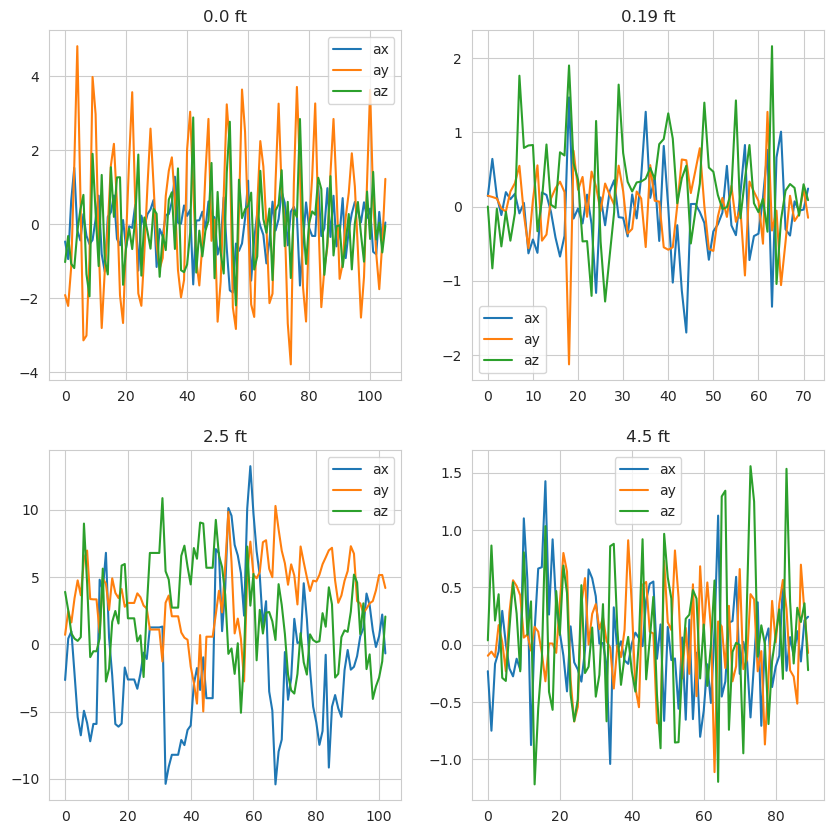

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    signals[i].plot(ax=ax, title=labels_unique[i])
plt.show()